# HyperLogLogs with Python
A HyperLogLog is a probabilistic data structure used to estimate the number of elements contained in a set, without having to store the whole set. HLLs are extensively used in big data pipelines, where storing all distinct elements often incurs a prohibitive cost.
The initial idea has been originally published in a paper by Flajolet et al. [1] (very worth reading), and various practical improvements have been proposed in [2].

I wrote this notebook to experiment with HLLs, and in particular with the memory/performance tradeoffs in Python. I'll write several implementations of HLL, which will be mostly standalone and won't share much code. This is intended, as I've observed that the overhead of calling functions (e.g., each time an element is added to the HLL) may have non-negligible impact on performance.

#### References
[1]: Flajolet, Philippe, et al. "Hyperloglog: the analysis of a near-optimal cardinality estimation algorithm." DMTCS Proceedings. 2008.

[2]: Heule, Stefan, et al. "HyperLogLog in practice: algorithmic engineering of a state of the art cardinality estimation algorithm." Proceedings of the 16th International Conference on Extending Database Technology. 2013.

## A Primer on HyperLogLog
Let $h(x)$ be a (perfectly uniform) hash of a given item $x$ and let $\rho(h(x))$ be the position of the leftmost `1` in $h(x)$. 

HLLs are based on the observation that if the maximum value taken by $\rho(h(x))$ over all values $v$ of a set $\mathcal{M}$ is $M$, then the cardinality of $\mathcal{M}$ is approximately $2^M$.

Although it holds on average, this estimation is very noisy (it uses a granularity in powers of two). To reduce this variability, HLLs maintain $m$ versions of $M$ in $m$ registers, which are written $M[j],\, 0 < j < m$.
Now, when an item $x$ is added to the set, the HLL updates a single register, whose index $j$ is taken from the first $p := \log_2(m)$ bits of $h(x)$, and $M[j]$ is set to $\max(M[j], \rho(h(v)[p:])$, where the notation $h(v)[p:]$ indicates that we consider only the bits of $h(v)$ starting at index $p$ (that is, the bits remaining after we choose $j$).

When estimating cardinality, one takes the harmonic mean of $2^{M[j]}\, 0 < j < m$. The harmonic mean is used to obtain low-variance estimates (compared to other kinds of averaging). It introduces biais, however. Fortunately, the biais can be computed (as a function of $m$) and compensated for [1]. They are denoted $\alpha(m)$.

## A Base Class for HLLs:
Let's start by defining a base class which provides `add()` and `estimate()` methods (respectively to add elements to the HLL and estimate the cardinality).

The variable $p$ denotes the number of bits used to adress the registers, and there are $m = 2^p$ registers.
The variable `nr_bits` denotes the number of bits stored in each registers (but it won't be used until later). The $\alpha$'s coefficients come from [1] and will be used in the estimation phase to compensate for the multiplicative biais.

In [5]:
from abc import ABCMeta, abstractmethod

class HLL(object):
    __metaclass__ = ABCMeta
    
    @abstractmethod
    def __init__(self, p=10, nr_bits=6):
        self.p = p
        self.m = 1 << p  # number of registers
        self.nr_bits = nr_bits  # number of bits per register (when applicable)
        small_alphas = {16: 0.673, 32: 0.697, 64: 0.709}
        if self.m in small_alphas:
            self.alpha = small_alphas[self.m]
        elif self.m >= 128:  # and ((self.m & (self.m - 1)) == 0):
            self.alpha = 0.7213/(1.0 + 1.079/ float(self.m))
    
    @abstractmethod
    def add(self, item):
        pass
    
    @abstractmethod
    def estimate(self):
        pass

## A Naive implementation:
When adding a new item $x$, both the register index $j$ and $\rho(h(v))$ need to be uniquely determined by $x$ in a pseudo-uniformly-at-random fashion. We can then just seed Python's PRNG with $x$ and use it to sample new random bits when needed.

In [6]:
import random
import math

class HLL1(HLL):
    def __init__(self, p):
        super(HLL1, self).__init__(p)
        self.registers = [0 for _ in xrange(self.m)]        
        
    def add(self, item):
        random.seed(item)
        
        # choose stream:
        j = random.choice(xrange(self.m))

        # count leading zeros:
        count = 1
        while True:
            if bool(random.getrandbits(1)) == 0:
                count += 1
            else:
                break
        self.registers[j] = count if count > self.registers[j] else self.registers[j]
    
    def estimate(self):
        Z = 1.0/sum([2.0 ** (-1.0 * Mj) for Mj in self.registers])
        E = self.alpha * self.m ** 2 * Z
        
        # small-range corrections:
        if E <= 2.5 * self.m:
            V = sum([1 for i in xrange(self.m) if self.registers[i] == 0])
            if V > 0:
                E = self.m * math.log(float(self.m)/float(V))
                
        # large-range corrections not needed as we don't have the 32-bit hash limitation of the original paper
        return E

### Accuracy/Performance Evaluation
I define below a function that I'll re-use throughout the notebook, whose purpose is to add `nr_experiments` times `N` elements to the HLL. For simplicity, I'll use integers.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

""" This function serves to both measure accuracy and as a performance benchmarks for
    many consecutive add() operations.
    
    N represents the cardinality. The data points themselves are chosen with a random offset
    between 0 and 2^64  (in order to generate different datasets w.h.p.)
"""
def measure_add(hll_impl=HLL1, p=10, nr_experiments=20, N=10000, plot=False, verbose=False):
    errors = []
    random.seed(1)  # we always use the same set of datasets for comparison
    for _ in xrange(nr_experiments):
        hll = hll_impl(p)
        offset = random.randint(0, long(math.pow(2,64)))
        for i in xrange(N):
            hll.add(offset + i)

        errors.append(N - hll.estimate())
        
        if verbose:
            print 'registers:', hll.registers
            print 'true cardinality:', len(ground_truth)
            print 'estimate:', hll.estimate()
            print 'standard error:', len(ground_truth) * 1.04/math.sqrt(float(m))
            
    if plot:
        plt.hist(np.array(errors)/float(N), bins=max(10, nr_experiments/3))
        plt.xlabel('relative error')
        plt.ylabel('count')
        plt.show()

Let's see how accurate our HLL is. The cell below should plot a rough histogram of the errors it makes.

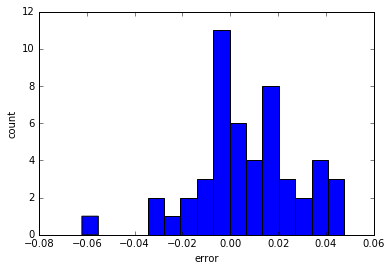

In [10]:
measure_add(plot=True, p=11, nr_experiments=50, N=20000)

And how it performs in terms of computation time:

In [ ]:
# and in terms of computing time:
import cProfile
cProfile.run('measure_add()')

The execution spends a lot of time in `function seed`. Let's try to avoid that.

### An implementation using a hash function:
Our first implementation above has the merit of being very simple, but it makes extensive use of calls to `random` functions, which can take a lot of time. We'll now try to write a HLL object that uses a (unique) hash of the added items (as proposed in the original paper). Note that it's important that the hash function be as uniform (or "cryptographic") as possible in order to guarantee the accuracy of estimates -- in particular, python's native `hash` function is very fast but not uniform. We use MD5 here.

In [ ]:
import hashlib

class HLL2(HLL):
    def __init__(self, p):
        super(HLL2, self).__init__(p)
        self.registers = [0 for _ in xrange(self.m)]
        self.registerMask = (1 << p) - 1
        
    def add(self, item):
        h = hash(hashlib.md5(str(item)).digest())  # TODO: improve; this is not satisfying (native hash is nonuniform)
        if h < 0: h = -h  # for easier bitwise operations
        
        j = h & self.registerMask

        for i in xrange(64 - self.p):
            if(h & (1 << self.p + i)) > 0:
                break

        self.registers[j] = i+1 if i+1 > self.registers[j] else self.registers[j]
    
    def estimate(self):
        Z = 1.0/sum([2.0 ** (-1.0 * Mj) for Mj in self.registers])
        E = self.alpha * self.m ** 2 * Z
        
        # small-range corrections:
        if E <= 2.5 * self.m:
            V = sum([1 for i in xrange(self.m) if self.registers[i] == 0])
            if V > 0:
                E = self.m * math.log(float(self.m)/float(V))
        return E    

In [ ]:
measure_add(hll_impl=HLL2, plot=True, nr_experiments=300, N=40000, p=11)

In [ ]:
cProfile.run('measure_add(hll_impl=HLL2)')

On my laptop, HLL2 is about 3-4 times faster than HLL1.

## Memory Consumption
We have an idea of the speed performance of our first two HLL implementations. Let's look now at the memory they consume (which can be an even more important aspect of HLLs).

It's difficult to measure the size taken by data structures in Python. The approach I take here is to dump the HLL registers to a file and (manually) get the size of the file, which I hope is a fairly accurate way of estimating the memory footprint used by the registers in practice. 

In [ ]:
import cPickle

print 'memory footprint of HLL1:', len(cPickle.dumps(HLL1(10), protocol=2)), 'B'
print 'memory footprint of HLL2:', len(cPickle.dumps(HLL2(10), protocol=2)), 'B'

In my case, for $p=10$ (and so $m=1024$ registers) the pickled HLL1 and HLL2 respectively take 2140 and 2159 bytes, which corresponds to approximately 2 bytes per register, plus some overhead.
Of course, this is inefficient, as each register needs only to store a quantity that is less than $H - p$, where $H$ is the length of the hash. If we take $H=64$, then using 6 bits per register is enough (irrespective of $p$).

### A Version Optimized for Memory Consumption
Let's try now to use only the required number of bits for the registers. First, I define some helper functions to map from int to bit string representation and back:

In [ ]:
# utility functions for bitarray <--> int conversions, assuming big endian
def repr_to_int(ar):
    """ Unfortunately for style, it's be possible to make this method slightly faster by writing this as a for loop.
        But impact is not huge and I'd rather not doing it.
    """
    return reduce(lambda nr, bit: (nr << 1) | bit, ar, 0)
        
def int_to_repr(number, nr_bits):
    return bitarray(map(lambda i: number & (1 << (nr_bits - i - 1)), xrange(nr_bits)))

In [ ]:
# Memory efficient implementation; first attempt
from bitarray import bitarray

class HLL3(HLL):
    def __init__(self, p, nr_bits=6):
        super(HLL3, self).__init__(p, nr_bits)
        self.nr_bits = nr_bits
        self.registers = bitarray([False for _ in xrange(self.m * nr_bits)])
        self.registerMask = (1 << p) - 1
        
    def add(self, item):
        h = hash(hashlib.md5(str(item)).digest())  # TODO: improve; this is not satisfying (native hash is nonuniform)
        if h < 0: h = -h  # for easier bitwise operations
        
        j = h & self.registerMask
        si = j*self.nr_bits  # stream index in our bitarray

        for i in xrange(64 - self.p):
            if(h & (1 << self.p + i)) > 0:
                break
                
        # compute small int representation using 'nr_bits' only
        existing = repr_to_int(self.registers[si:si+self.nr_bits])  # one could avoid this function call for speed
        # self.update_registers(si, i+1 if i+1 > existing else existing)
        self.registers[si:si+self.nr_bits] = int_to_repr(i+1 if i+1 > existing else existing, self.nr_bits)
    
    def estimate(self):
        Z = 1.0/sum([2.0 ** (-1.0 * repr_to_int(Mj)) for Mj in zip(*(iter(self.registers),) * self.nr_bits)])
        E = self.alpha * self.m ** 2 * Z
        
        # small-range corrections:
        if E <= 2.5 * self.m:
            V = sum([1 for i in xrange(self.m) if self.registers[i] == 0])
            if V > 0:
                E = self.m * math.log(float(self.m)/float(V))
        return E

I've used a `bitarray` for the registers here. It's also possible (and actually slightly faster) to implement this with a regular boolean array, but as far as I've seen Python uses 1 byte to represent booleans, which means that the memory consumption is about 8 times higher (!).

So how does the `bitarray` perform in terms of speed and memory consumption?

In [ ]:
print 'memory footprint of HLL3:', len(cPickle.dumps(HLL3(10), protocol=2)), 'B\n'
cProfile.run('measure_add(hll_impl=HLL3)')
measure_add(hll_impl=HLL3, plot=True, nr_experiments=100, N=40000, p=11)

In my case, storing an HLL3 with 6-bit registers takes 912 bytes, which is not so far from the 768 bytes required to store the 1024 registers alone.

Note: storing only the registers takes 811 bytes, which is even closer to optimal -- the additional 101 bytes come from remaining instance variables and could be trimmed down further by implementing proper serialization (see later).

Note 2: Using 5-bit registers (which are OK until cardinalities reach about $2^{32}$) allows to further reduce memory footprint to 784 bytes for storing an HLL3.

Unfortunately though, HLL3 is significantly slower than HLL2, with speed more similar to HLL1.
Let's see if we can strike a balance between memory and speed by using a full byte per register, using a Python `array` containing unsigned bytes.

### Using an Array of byte

In [ ]:
import array

class HLL4(HLL):
    def __init__(self, p):
        super(HLL4, self).__init__(p)
        self.registers = array.array('B', [0 for _ in xrange(self.m)])
        self.registerMask = (1 << p) - 1
            
    def add(self, item):
        h = hash(hashlib.md5(str(item)).digest())  # TODO: improve; this is not satisfying (native hash is nonuniform)
        if h < 0: h = -h  # for easier bitwise operations
        
        j = h & self.registerMask
        
        for i in xrange(64 - self.p):
            if(h & (1 << self.p + i)) > 0:
                break
        
        self.registers[j] = i+1 if i+1 > self.registers[j] else self.registers[j]
    
    def estimate(self):
        Z = 1.0/sum([2.0 ** (-1.0 * Mj) for Mj in self.registers])
        E = self.alpha * self.m ** 2 * Z
        
        # small-range corrections:
        if E <= 2.5 * self.m:
            V = sum([1 for i in xrange(self.m) if self.registers[i] == 0])
            if V > 0:
                E = self.m * math.log(float(self.m)/float(V))
        return E

In [ ]:
print 'memory footprint:', len(cPickle.dumps(HLL4(10), protocol=2)), 'B\n'
cProfile.run('measure_add(hll_impl=HLL4)')

HLL4 is faster than HLL3 with performance similar to HLL2. Unfortunately though, memory efficiency is not better than HLL2, as a pickled HLL4 takes 2181 bytes.

### Using Numpy Arrays
`numpy` also proposes an 8-bit int type; let's try it (the code is essentially the same).

In [ ]:
import numpy as np

class HLL5(HLL):
    def __init__(self, p):
        super(HLL5, self).__init__(p)
        self.registers = np.zeros((self.m,), dtype=np.int8)
        self.registerMask = (1 << p) - 1
            
    def add(self, item):
        h = hash(hashlib.md5(str(item)).digest())  # TODO: improve; this is not satisfying (native hash is nonuniform)
        if h < 0: h = -h  # for easier bitwise operations
        
        j = h & self.registerMask
        
        for i in xrange(64 - self.p):
            if(h & (1 << self.p + i)) > 0:
                break
        
        self.registers[j] = i+1 if i+1 > self.registers[j] else self.registers[j]
    
    def estimate(self):
        Z = 1.0/sum([2.0 ** (-1.0 * Mj) for Mj in self.registers])
        E = self.alpha * self.m ** 2 * Z
        
        # small-range corrections:
        if E <= 2.5 * self.m:
            V = sum([1 for i in xrange(self.m) if self.registers[i] == 0])
            if V > 0:
                E = self.m * math.log(float(self.m)/float(V))     
        return E

In [ ]:
print 'memory footprint:', len(cPickle.dumps(HLL5(10), protocol=2)), 'B\n'
cProfile.run('measure_add(hll_impl=HLL5)')

HLL5 performs a bit slower than HLL4, but requires less memory -- 1258 bytes in my case.

### Small Memory and High Insertion Speed
Let's now try to use `array` for computation and `bitarray` for serialization.

In [ ]:
import array

class HLL6(HLL):
    def __init__(self, p, nr_bits=6):
        super(HLL6, self).__init__(p, nr_bits)
        self.registers = array.array('B', [0 for _ in xrange(self.m)])
        self.registerMask = (1 << p) - 1
            
    def add(self, item):
        h = hash(hashlib.md5(str(item)).digest())  # TODO: improve; this is not satisfying (native hash is nonuniform)
        if h < 0: h = -h  # for easier bitwise operations

        j = h & self.registerMask
        
        for i in xrange(64 - self.p):
            if(h & (1 << self.p + i)) > 0:
                break
        
        self.registers[j] = i+1 if i+1 > self.registers[j] else self.registers[j]
    
    def estimate(self):
        Z = 1.0/sum([2.0 ** (-1.0 * Mj) for Mj in self.registers])
        E = self.alpha * self.m ** 2 * Z
        
        # small-range corrections:
        if E <= 2.5 * self.m:
            V = sum([1 for i in xrange(self.m) if self.registers[i] == 0])
            if V > 0:
                E = self.m * math.log(float(self.m)/float(V))
        return E
    
    def __setstate__(self, odict):
        p = odict['p']
        nr_bits = odict['nr_bits']
        super(HLL6, self).__init__(p, nr_bits)
        expandedRegs = [repr_to_int(odict['registers'][nr_bits*i:nr_bits*(i+1)]) for i in xrange(self.m)]
        self.registers = array.array('B', expandedRegs)
        self.registerMask = (1 << p) - 1
    
    def __getstate__(self):
        compactRegs = bitarray([False for _ in xrange(self.m * self.nr_bits)])
        for i in xrange(self.m):
            compactRegs[self.nr_bits*i:self.nr_bits*(i+1)] = int_to_repr(self.registers[i], self.nr_bits)
        return {'registers': compactRegs, 'p': self.p, 'nr_bits': self.nr_bits}

In [ ]:
print 'memory footprint:', len(cPickle.dumps(HLL6(10, 6), protocol=2)), 'B\n'
cProfile.run('measure_add(hll_impl=HLL6)')

Let's also quickly check that our serialization actually works:

In [ ]:
hll = HLL6(10, 6)
for i in xrange(10000):
    hll.add(i)
print 'estimate:', hll.estimate()
with open('hll6.pkl', 'wb') as f:
    cPickle.dump(hll, f)
with open('hll6.pkl', 'rb') as f:
    hll_pickled = cPickle.load(f)
print 'estimate from pickled version:', hll_pickled.estimate()

It should work. So HLL6 is fast for adding elements, and serializes into a compact version that takes 869 bytes to store 1024 6-bit registers, $p$ and the number of bits per register.

Note however that there is additional overhead for serialization now. Depending on the use case (eg., whether one does frequent additions with the HLL in memory, or frequent write/read of the HLL to disk), one may want to go for one of the other options proposed above.
Also, I've focused on addition of new elements for performance, but it could be the case that estimation are required more often and are important as well. I'll try to assess performance of estimations at some point.